# PETITE Tutorial
Authors: Kevin J. Kelly (Texas A&M), Nikita Blinov (U. Victoria), Ryan Plestid (Caltech), Patrick J. Fox (Fermilab), and Pedro A.M. Machado (Fermilab)

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers, with or without new physics.
Currently, dark photons with pure vector couplins are incorporated in PETITE.

PETITE includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 
* Moller Scattering $e^- e^- \rightarrow e^- e^-$
* Bhabha Scattering $e^+ e^- \rightarrow e^+ e^-$

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Feb13_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/Mar24_xSec_Dicts_neval.pkl

You can check versions with the code below and adjust if necessary.

In this tutorial you will learn how to 
1. Initialize PETITE
2. Generate a standard electromagnetic shower
3. Generate a shower with a dark photon
4. Analyze the accept/reject method used by PETITE, based on precomputed shower samples
5. Understand how to generate novel shower samples.

In [16]:
# Force reload (if changes have been made to the module)
%load_ext autoreload
%autoreload 2

# Initialization of the tutorial
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)
# folder where VEGAS dictionaries are stored
#dictionary_dir = "data/VEGAS_dictionaries/"
dictionary_dir = "lightmasses_fine/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.11.3
Numpy version:  1.24.2
PETITE home directory: /Users/ryanplestid/Documents/GitHub/PETITE/


In [17]:
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib

E0 = 10. # energy of incident particle in GeV
# Define incident electron
px, py, pz = 0, 0, np.sqrt(E0**2 - 0.000511**2)
# dictionary with particle properties
# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID':11, 'ID':0, 'generation_number':0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)

# Shower(directory, material, minimum_energy)
print(PETITE_home_dir+dictionary_dir)
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.010,fast_MCS_mode=False)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.010,fast_MCS_mode=False)
# Generate standard shower for graphite and lead, let's do some verbosity to see what's going on
standard_shower_graphite = sGraphite.generate_shower(p0, VB=True)
standard_shower_lead = sLead.generate_shower(p0, VB=True)


/Users/ryanplestid/Documents/GitHub/PETITE/lightmasses_fine/
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable'}
Initial four-momenta:
[10.          0.          0.          9.99999999]
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable'}
Initial four-momenta:
[10.          0.          0.          9.99999999]


/opt/homebrew/lib/python3.11/site-packages/PETITE/moliere.py:62: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(integrand, 0., x)[0]


### Load in dependencies and set font styles

In [55]:
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import tqdm

import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ Helper function to set figure size.
        Input:
            w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



####  Outline

- Generating standard model shower
- Generating dark photon shower
- Plotting acceptance
- Plotting individual processes
- Generating novel shower samples
- Analyzing accept-reject method in PETITE

## Shower production with PETITE

The primary purpose of PETITE is to produce realistic electromagnetic showers with a lightweight, reasonably fast, python-native code base. We illustrate its performance below. 

We will shoot a 10 GeV particle incident on either lead or graphite. Particles are specified by their PDG codes (see e.g. https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf). Units in PETITE are GeV, cm, and radians.

* ${\rm PDG}(e^\pm)=\pm11$ 
* ${\rm PDG}(\gamma)~~=+22$ 


In [56]:
E0 = 10. # energy of incident particle in GeV
# Define incident electron
px, py, pz = 0, 0, np.sqrt(E0**2 - 0.000511**2)
# dictionary with particle properties
# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID':11, 'ID':0, 'generation_number':0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)

# Fast MCS Mode

In [57]:
# Shower(directory, material, minimum_energy)
print(PETITE_home_dir+dictionary_dir)
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.010)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.010)
# Generate standard shower for graphite and lead, let's do some verbosity to see what's going on
standard_shower_graphite = sGraphite.generate_shower(p0, VB=True)
standard_shower_lead = sLead.generate_shower(p0, VB=True)

/Users/ryanplestid/Documents/GitHub/PETITE/lightmasses_fine/
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable'}
Initial four-momenta:
[10.          0.          0.          9.99999999]
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable'}
Initial four-momenta:
[10.          0.          0.          9.99999999]


The shower is now generated. The object standard_shower_graphite is a list of particles generated throughout the shower. We can look at some of their properties.

Total number of particles:  663
Number of (photons, electrons, positrons):  150 344 169


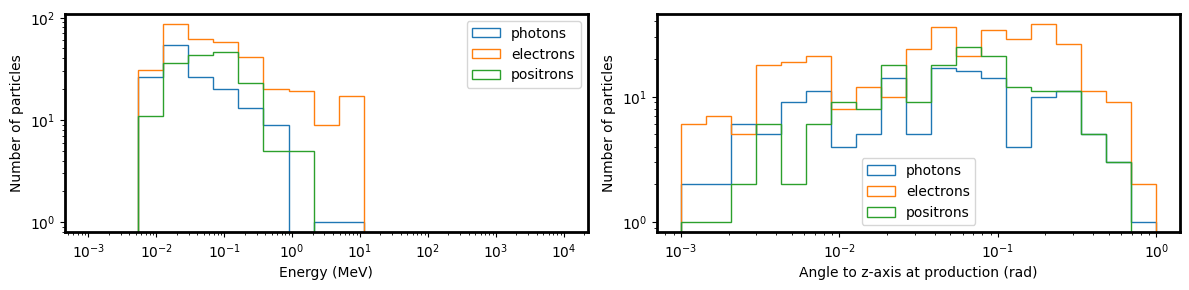

In [51]:
# Let's look at different particles in the shower and their properties.
print('Total number of particles: ', len(standard_shower_graphite))
photons = [p for p in standard_shower_graphite if p.get_pid() == 22]
electrons = [p for p in standard_shower_graphite if p.get_pid() == 11]
positrons = [p for p in standard_shower_graphite if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))
# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

Total number of particles:  1487
Number of (photons, electrons, positrons):  306 607 574


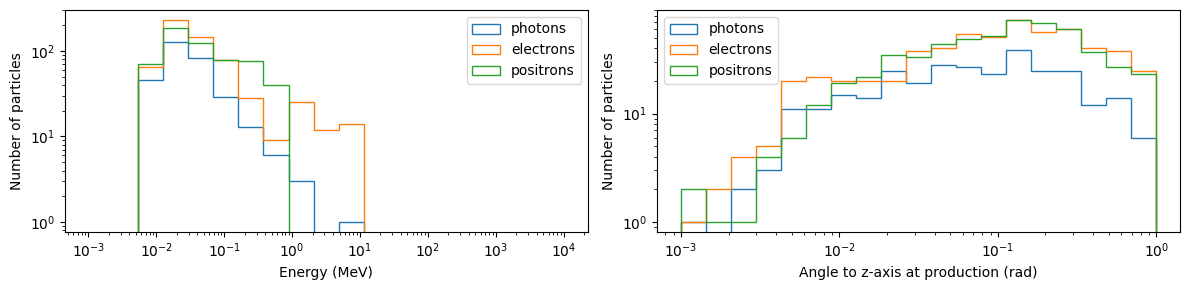

In [29]:
# Let's look at different particles in the shower and their properties.
print('Total number of particles: ', len(standard_shower_lead))
photons = [p for p in standard_shower_lead if p.get_pid() == 22]
electrons = [p for p in standard_shower_lead if p.get_pid() == 11]
positrons = [p for p in standard_shower_lead if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))
# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

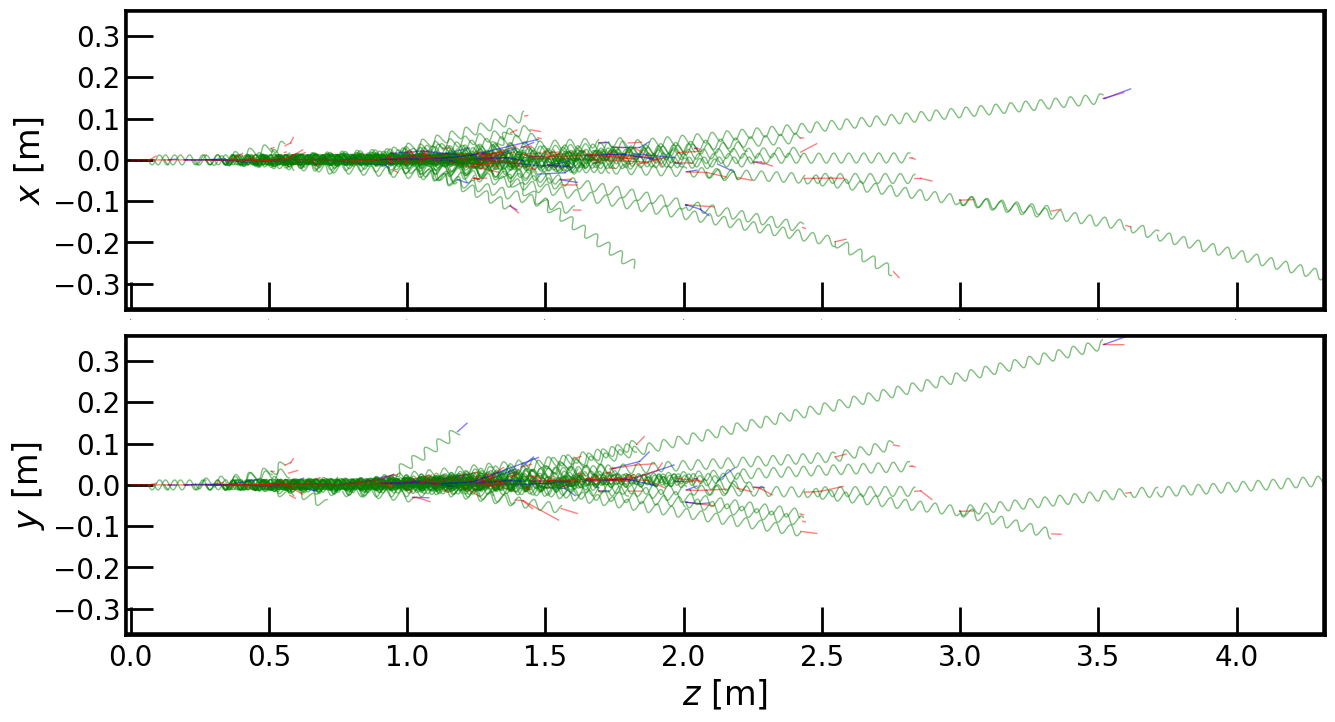

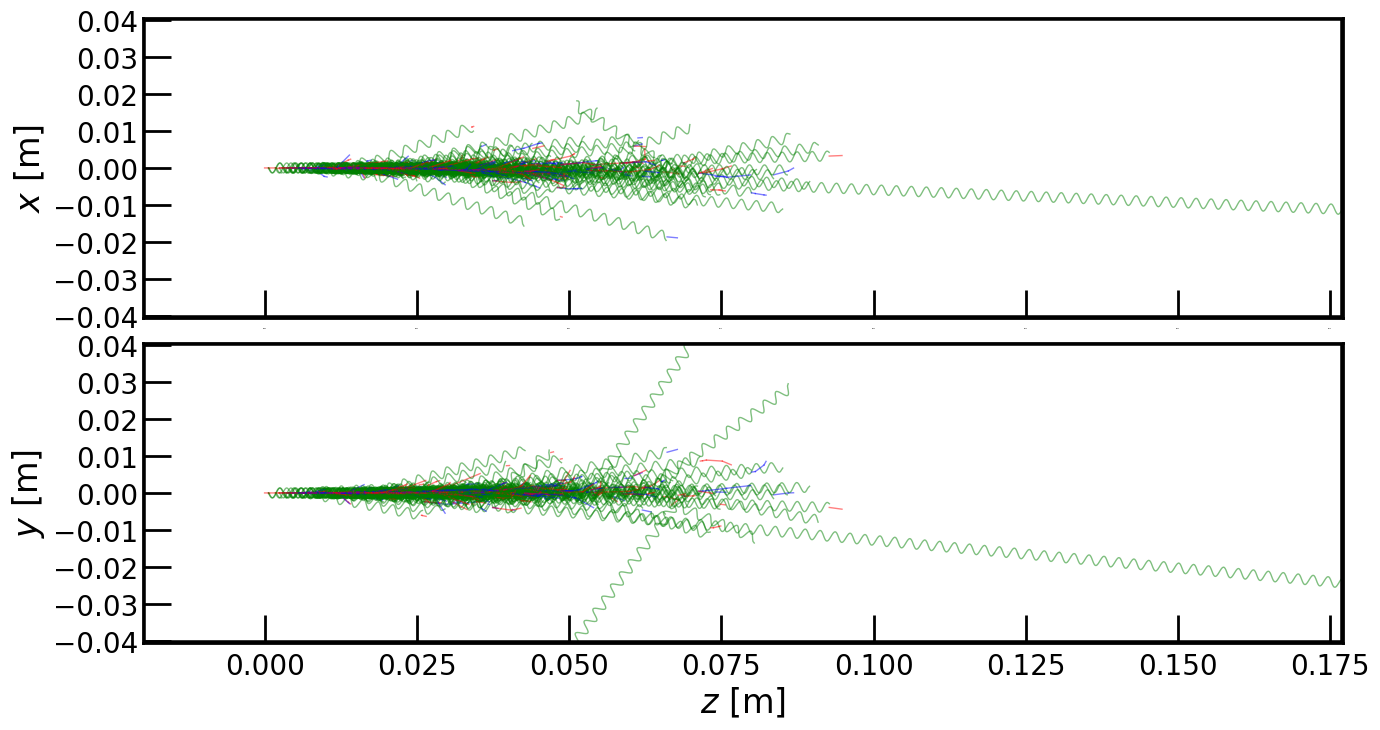

In [30]:
# We can also see the shower display for both graphite and lead
event_display(standard_shower_graphite)
event_display(standard_shower_lead)

Pretty neat, no? Notice the difference in the z-range, which is just a consequence of the smaller mean free path in lead.

####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

Now we create a list of energies to be used in the simulation.

In [31]:
EVec = np.logspace(np.log10(0.0015), np.log10(100.), 100)
EVec[58], EVec[73]

(1.0051239289306901, 5.4089737788907355)

# "Bethe" MCS mode 

In [60]:
# Shower(directory, material, minimum_energy)
print(PETITE_home_dir+dictionary_dir)
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.010,fast_MCS_mode=False)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.010,fast_MCS_mode=False)
# Generate standard shower for graphite and lead, let's do some verbosity to see what's going on
standard_shower_graphite = sGraphite.generate_shower(p0, VB=True)
standard_shower_lead = sLead.generate_shower(p0, VB=True)

/Users/ryanplestid/Documents/GitHub/PETITE/lightmasses_fine/
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable'}
Initial four-momenta:
[10.          0.          0.          9.99999999]
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable'}
Initial four-momenta:
[10.          0.          0.          9.99999999]


ValueError: math domain error

The shower is now generated. The object standard_shower_graphite is a list of particles generated throughout the shower. We can look at some of their properties.

Total number of particles:  650
Number of (photons, electrons, positrons):  151 317 182


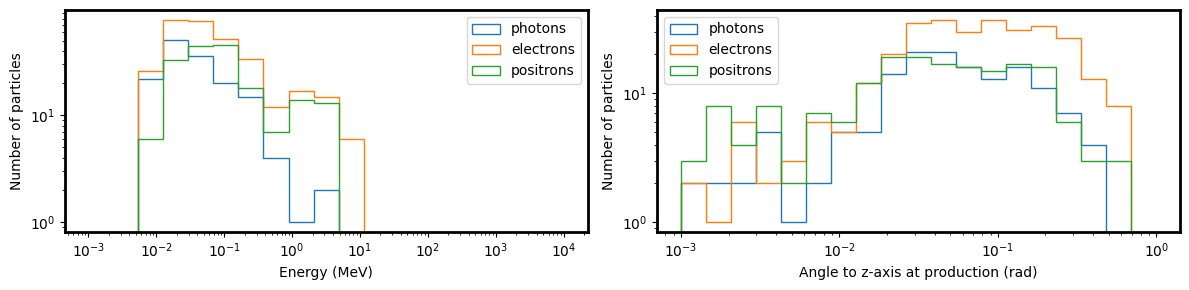

In [33]:
# Let's look at different particles in the shower and their properties.
print('Total number of particles: ', len(standard_shower_graphite))
photons = [p for p in standard_shower_graphite if p.get_pid() == 22]
electrons = [p for p in standard_shower_graphite if p.get_pid() == 11]
positrons = [p for p in standard_shower_graphite if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))
# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

Total number of particles:  1487
Number of (photons, electrons, positrons):  306 607 574


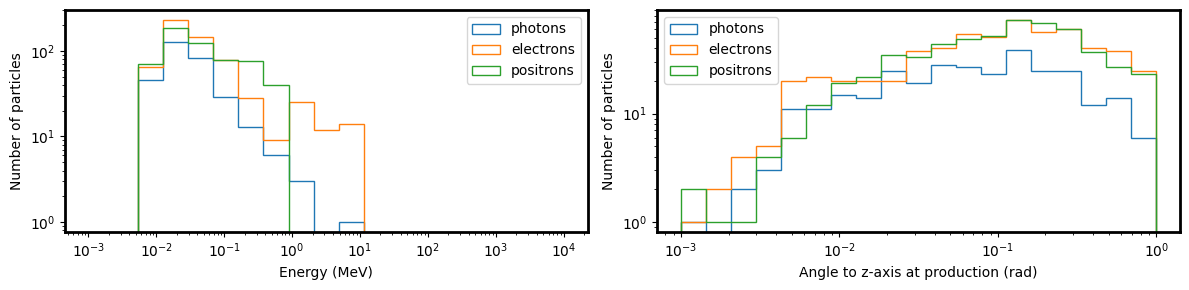

In [34]:
# Let's look at different particles in the shower and their properties.
print('Total number of particles: ', len(standard_shower_lead))
photons = [p for p in standard_shower_lead if p.get_pid() == 22]
electrons = [p for p in standard_shower_lead if p.get_pid() == 11]
positrons = [p for p in standard_shower_lead if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))
# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

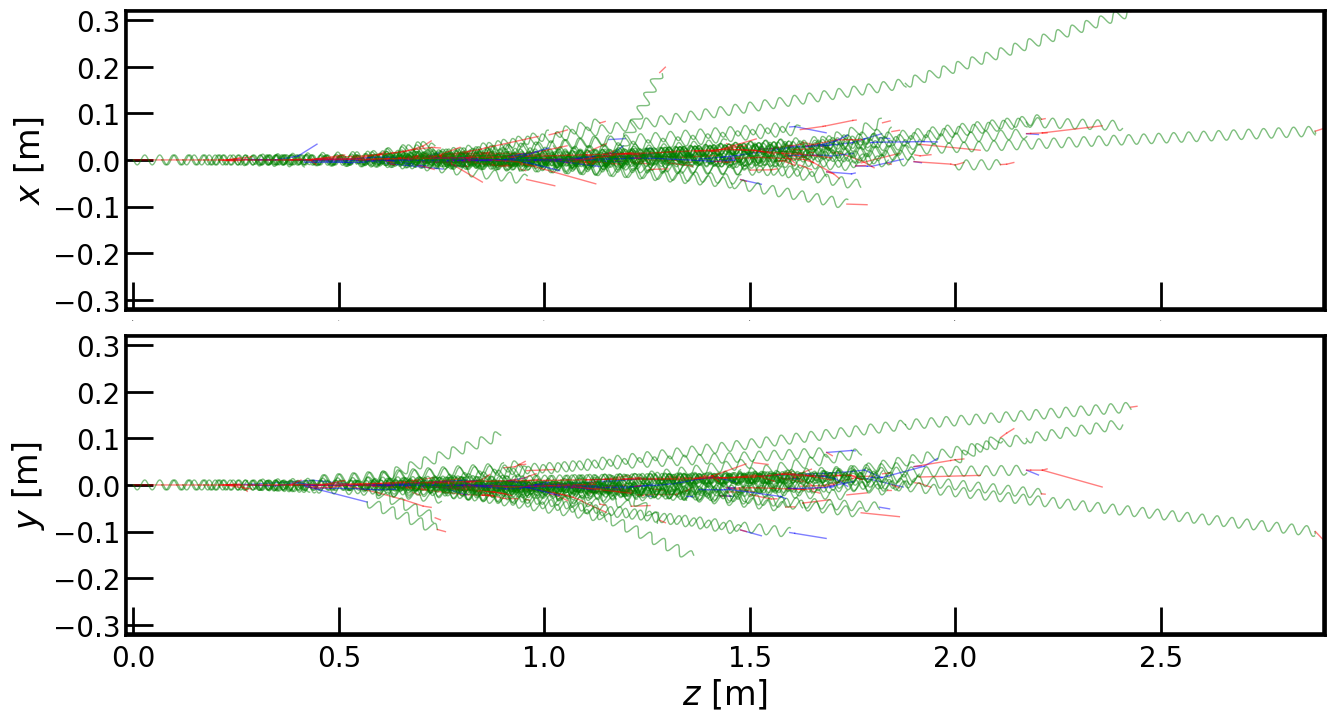

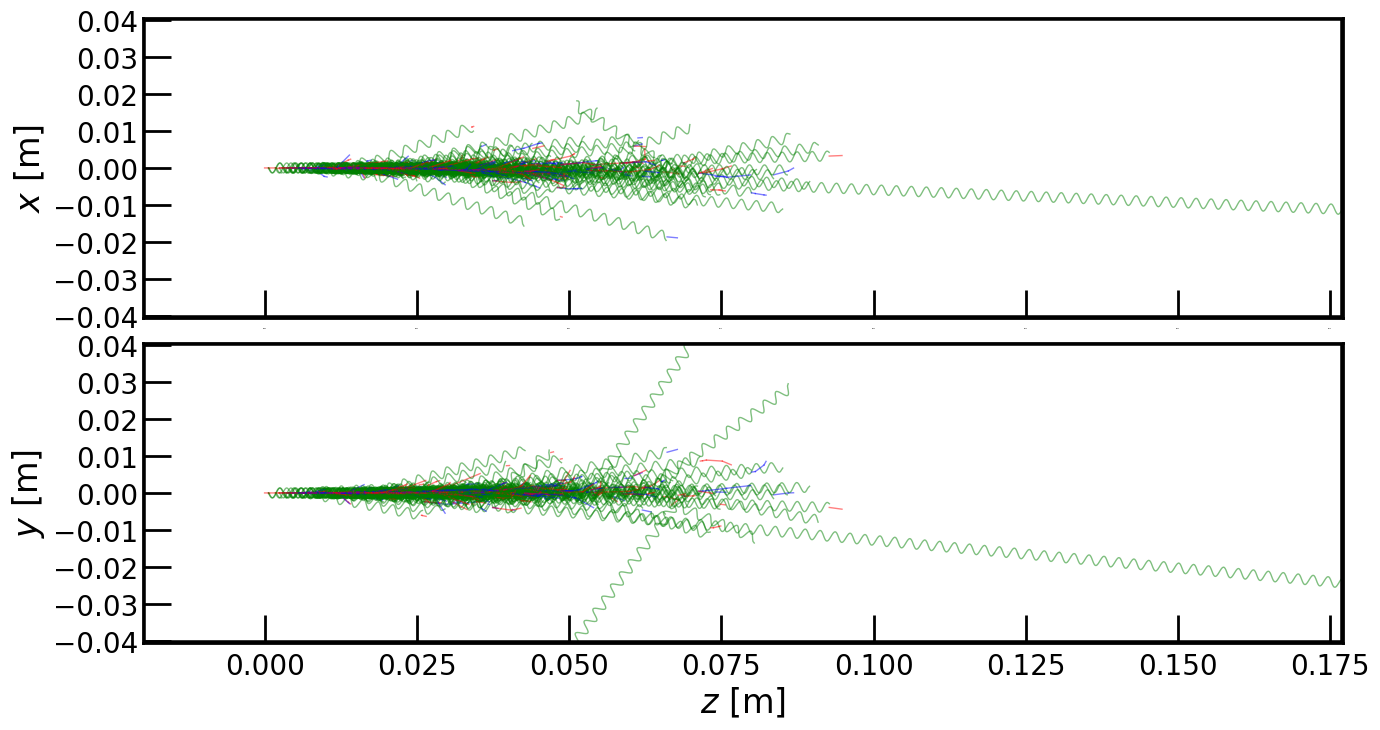

In [35]:
# We can also see the shower display for both graphite and lead
event_display(standard_shower_graphite)
event_display(standard_shower_lead)

Pretty neat, no? Notice the difference in the z-range, which is just a consequence of the smaller mean free path in lead.

####  Import two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

Now we create a list of energies to be used in the simulation.

In [31]:
EVec = np.logspace(np.log10(0.0015), np.log10(100.), 100)
EVec[58], EVec[73]

(1.0051239289306901, 5.4089737788907355)